In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pickle as pl
from time import time
from random import shuffle
from torch import nn
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, Subset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.model_selection import StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
READ_FROM_CACHE = True

EPOCHS = 32
LR = 0.00001
LR_DECREASE = 0.1
BATCH_SIZE = 96
WEIGHT_DECAY = 0.0001
DROP_OUT = 0.3
PATIENCE = 5
LOSS_DELTA = 0.001
GRADIENT_CLIPPING = 0.05
EMBED_DIM = 64
K = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
class HateSpeechDataset(Dataset):
    def __init__(self, contents):
        super(HateSpeechDataset, self).__init__()
        self.contents = contents
        self.nClasses = 3

    def __getitem__(self, index):
        return self.contents[index]
    
    def __len__(self):
        return len(self.contents)

In [4]:
def get_class(annotations):
    score = 0
    for a in annotations:
        if a['label'] == 'hatespeech':
            score += 2
        elif a['label'] == 'offensive':
            score += 1
        elif a['label'] == 'normal':
            pass
        else:
            print('Unknown label:', a['label'])
            exit(1)

    return 2 if score >= 5 else 1 if score >= 2 else 0

def can_int(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

def build(data, path, invert=False):
    data_entries = []
    dir = os.listdir(path)

    numericise_labels = lambda l: 2 if l == 'hate' else 1 if l == 'relation' else 0 if l == 'noHate' else l
    standardise_labels = lambda l: 2 if l >= 1.0 else 1 if l >= 0.5 else 0
    invert_labels = lambda l: 2 - l

    for entry in data: 
        id = str(entry[0])
        file = f'{id}.txt'
        if file not in dir:
            if can_int(entry[0]):
                id = f'{int(entry[0]):06d}'
                file = f'{id}.txt'
                if file not in dir:
                    continue
            else:
                continue

        if invert: entry[1] = invert_labels(entry[1])
        entry[1] = numericise_labels(entry[1])
        if type(entry[1]) == float: entry[1] = standardise_labels(entry[1])

        contents = open(os.path.join(path, file), mode='r', encoding='utf-8').read()
        entry.append(contents)

        if entry[1] == 'idk/skip':
            continue
        
        try:
            datum = tuple(entry[1:])
            if datum in data_entries:
                print('Duplicate entry:', datum)
                continue
            else:
                data_entries.append(datum)
        except:
            print('Could not allocate:', id)
    
    return data_entries

def cache(path, data):
    try:
        with open(path, 'wb') as file:
            pl.dump(data, file)
    except:
        print(f'Could not cache data at {path}')

vicomtech_path = 'data/Vicomtech-hate-speech-dataset'
vicomtech_all_path = os.path.join(vicomtech_path, 'all_files')
vicomtech_path_list = [os.path.join(vicomtech_all_path, f) for f in os.listdir(vicomtech_all_path)]

avaapm_path = 'data/avaapm-hatespeech'
tweets_path = os.path.join(avaapm_path, 'tweetdata')
avaapm_path_list = [os.path.join(tweets_path, f) for f in os.listdir(tweets_path)]

ucberkeley_path = 'data/UCBerkeley-DLab-measuring-hate-speech'
ucberkeley_all_path = os.path.join(ucberkeley_path, 'all_files')
ucberkeley_path_list = [os.path.join(ucberkeley_all_path, f) for f in os.listdir(ucberkeley_all_path)]

hatexplain_path = 'data/hate-alert-HateXplain'
hatexplain_all_path = os.path.join(hatexplain_path, 'all_files')
hatexplain_path_list = [os.path.join(hatexplain_all_path, f) for f in os.listdir(hatexplain_all_path)]

tdavidson_path = 'data/t-davidson-hate-speech-and-offensive-language'
tdavidson_all_path = os.path.join(tdavidson_path, 'all_files')
tdavidson_path_list = [os.path.join(tdavidson_all_path, f) for f in os.listdir(tdavidson_all_path)]

data_cache_path = 'data/data.pkl'

if os.path.isfile(data_cache_path) and READ_FROM_CACHE: 
    with open(data_cache_path, 'rb') as file:
        all_data = pl.load(file)[0]

else:
    train_path = os.path.join(vicomtech_path, 'sampled_train')
    test_path = os.path.join(vicomtech_path, 'sampled_test')
    vicomtech_data = pd.read_csv(os.path.join(vicomtech_path, 'annotations_metadata.csv'), usecols=['file_id', 'label']).values.tolist()

    avaapm_id_list = [int(f[:-4]) for f in os.listdir(tweets_path)]
    avaapm_csv = pd.read_csv(os.path.join(avaapm_path, 'label.csv'), usecols=['TweetID', 'LangID', 'HateLabel'])
    avaapm_csv_en = avaapm_csv[avaapm_csv['LangID'] == 1]
    filtered_csv_en = avaapm_csv_en[avaapm_csv_en['TweetID'].isin(avaapm_id_list)]
    avaapm_data = filtered_csv_en[['TweetID', 'HateLabel']].values.tolist()

    ucberkeley_data = pd.read_csv(os.path.join(ucberkeley_path, 'label.csv'), usecols=['id', 'hate_speech_score']).values.tolist()

    hatexplain_df = pd.read_json(os.path.join(hatexplain_path, 'dataset.json')).T
    hatexplain_df = hatexplain_df[['post_id', 'annotators']]
    hatexplain_df['annotators'] = hatexplain_df['annotators'].apply(get_class)
    hatexplain_data = hatexplain_df.values.tolist()

    tdavidson_df = pd.read_csv(os.path.join(tdavidson_path, 'label.csv'), usecols=['class'])
    tdavidson_df['id'] = [f'{int(i):06d}' for i in tdavidson_df.index]
    tdavidson_data = tdavidson_df[['id', 'class']].values.tolist()

    all_data = []
    all_data += build(vicomtech_data, vicomtech_all_path)
    all_data += build(avaapm_data, tweets_path)
    all_data += build(ucberkeley_data, ucberkeley_all_path)
    all_data += build(hatexplain_data, hatexplain_all_path)
    all_data += build(tdavidson_data, tdavidson_all_path, invert=True)
    all_data = list(set(all_data))

    cache(data_cache_path, all_data)

dataset = HateSpeechDataset(all_data)

In [5]:
tokenizer_path = 'tokenizer.json'
if os.path.isfile(tokenizer_path) and READ_FROM_CACHE:
    tokenizer = Tokenizer.from_file(tokenizer_path)
else:
    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer_path_list = vicomtech_path_list + avaapm_path_list + ucberkeley_path_list + hatexplain_path_list + tdavidson_path_list
    shuffle(tokenizer_path_list)
    tokenizer.train(tokenizer_path_list, trainer=BpeTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]))
    tokenizer.save(tokenizer_path)

text_pipeline = lambda x: tokenizer.encode(x).ids

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

kf = StratifiedKFold(n_splits=K, shuffle=True)

In [6]:
class ClassifierNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(ClassifierNN, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.hidden_size1 = 128
        self.hidden_size2 = 64
        self.fc1 = nn.Linear(embed_dim, self.hidden_size1)
        self.fc2 = nn.Linear(self.hidden_size1, self.hidden_size2)
        self.fc3 = nn.Linear(self.hidden_size2, num_class)
        self.dropout = nn.Dropout(DROP_OUT)
        self.batch_norm1 = nn.BatchNorm1d(self.hidden_size1)
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_size2)
        self.activation = nn.LeakyReLU()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()
        self.fc3.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        hidden = self.fc1(embedded)
        hidden = self.batch_norm1(hidden)
        hidden = self.activation(hidden)
        hidden = self.dropout(hidden)

        hidden = self.fc2(hidden)
        hidden = self.batch_norm2(hidden)
        hidden = self.activation(hidden)
        hidden = self.dropout(hidden)

        output = self.fc3(hidden)
        return output

In [7]:
def minutes(t):
    mins = int(t // 60)
    secs = t % 60
    if mins > 0:
        return '{:3d}m {:2.1f}s'.format(mins, secs)
    else:
        return ' {:2.1f}s'.format(secs)

vocab_size = tokenizer.get_vocab_size()
total_accuracy = None
fold_results = []

all_train_scores = []
all_val_scores = []
all_train_losses = []
all_val_losses = []
all_epoch_durations = []
all_false_positives = []
all_false_negatives = []
total_val_size = 0

start_time = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset, [d[0] for d in all_data])):
    print(f'Fold {fold + 1}/{K}')
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
    
    model = ClassifierNN(vocab_size, EMBED_DIM, dataset.nClasses).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECREASE, patience=2)
    scaler = GradScaler()

    best_loss = float('inf')
    patience_counter = 0
    total_accuracy = None

    display_training = False
    training_scores = []
    training_losses = []
    validation_losses = []
    validation_scores = []
    epoch_durations = []

    false_positives_hate = 0
    false_negatives_hate = 0
    false_positives_maybe = 0
    false_negatives_maybe = 0

    def train(dataloader):
        model.train()
        total_acc, total_count = 0, 0
        log_interval = 500

        global display_training, train_loss

        for id, (label, text, offsets) in enumerate(dataloader):
            optimizer.zero_grad()
            with autocast(device_type=device.type):
                predicted_label = model(text, offsets)
                loss = criterion(predicted_label, label)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
            scaler.step(optimizer)
            scaler.update()
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            train_loss += loss.item()
            if id % log_interval == 0 and id > 0:
                display_training = True
                score = total_acc / total_count
                training_scores.append(score)
                print(f'epoch {epoch:3d} | {id:5d}/{len(dataloader):5d} batches | accuracy: {score:8.3f}')
                total_acc, total_count = 0, 0

    def evaluate(dataloader):
        global val_loss, false_positives_hate, false_negatives_hate, false_positives_maybe, false_negatives_maybe
        model.eval()
        total_acc, total_count = 0, 0

        with torch.no_grad(), autocast(device_type=device.type):
            for _, (label, text, offsets) in enumerate(dataloader):
                predicted_label = model(text, offsets)
                total_acc += (predicted_label.argmax(1) == label).sum().item()

                false_positives_hate += ((predicted_label.argmax(1) == 2) & (label != 2)).sum().item()
                false_negatives_hate += ((predicted_label.argmax(1) != 2) & (label == 2)).sum().item()
                false_positives_maybe += ((predicted_label.argmax(1) == 1) & (label != 1)).sum().item()
                false_negatives_maybe += ((predicted_label.argmax(1) != 1) & (label == 1)).sum().item()

                total_count += label.size(0)
                val_loss += criterion(predicted_label, label).item()
        return total_acc / total_count

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time()

        train_loss = 0
        train(train_loader)
        train_loss /= len(train_loader)

        val_loss = 0
        validation_accuracy = evaluate(val_loader)
        val_loss /= len(val_loader)

        if total_accuracy is not None and total_accuracy > validation_accuracy:
            scheduler.step(metrics=validation_accuracy)
        else:
            total_accuracy = validation_accuracy

        validation_scores.append(validation_accuracy)
        epoch_length = time() - epoch_start_time
        epoch_durations.append(epoch_length)
        training_losses.append(train_loss)
        validation_losses.append(val_loss)
        print(f'end of epoch {epoch:3d} | time: {epoch_length:5.2f}s | accuracy: {validation_accuracy:8.3f} | training loss: {train_loss:8.3f} | validation loss: {val_loss:8.3f}')

        if val_loss < best_loss - LOSS_DELTA:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= PATIENCE:
            print('early stopping.')
            break

    all_train_scores.append(training_scores)
    all_val_scores.append(validation_scores)
    all_train_losses.append(training_losses)
    all_val_losses.append(validation_losses)
    all_epoch_durations.append(epoch_durations)
    all_false_positives.append((false_positives_hate, false_positives_maybe))
    all_false_negatives.append((false_negatives_hate, false_negatives_maybe))
    fold_results.append((val_loss, validation_accuracy))
    total_val_size += len(val_subset)

print("training finished in" + minutes(time() - start_time) + "\n\nChecking the results:")

avg_loss = sum([result[0] for result in fold_results]) / K
avg_accuracy = sum([result[1] for result in fold_results]) / K
avg_false_positive_hate = sum([instance[0] for instance in all_false_positives]) / total_val_size / K
avg_false_negative_hate = sum([instance[0] for instance in all_false_negatives]) / total_val_size / K
avg_false_positive_maybe = sum([instance[1] for instance in all_false_positives]) / total_val_size / K
avg_false_negative_maybe = sum([instance[1] for instance in all_false_negatives]) / total_val_size / K

print(f'Average Validation Loss: {avg_loss:.4f}, Average Accuracy: {avg_accuracy:.4f}\nFalse Positive Rate (Hate): {avg_false_positive_hate:.4f}, False Negative Rate (Hate): {avg_false_negative_hate:.4f}, Average False Positives (Maybe Hate): {avg_false_positive_maybe:.4f}, Average False Negatives (Maybe Hate): {avg_false_negative_maybe:.4f}')

Fold 1/10
epoch   1 |   500/ 1288 batches | accuracy:    0.333
epoch   1 |  1000/ 1288 batches | accuracy:    0.434
end of epoch   1 | time: 18.09s | accuracy:    0.617 | training loss:    1.221 | validation loss:    0.901
epoch   2 |   500/ 1288 batches | accuracy:    0.569
epoch   2 |  1000/ 1288 batches | accuracy:    0.622
end of epoch   2 | time: 16.97s | accuracy:    0.711 | training loss:    0.920 | validation loss:    0.771
epoch   3 |   500/ 1288 batches | accuracy:    0.678
epoch   3 |  1000/ 1288 batches | accuracy:    0.692
end of epoch   3 | time: 16.97s | accuracy:    0.740 | training loss:    0.785 | validation loss:    0.686
epoch   4 |   500/ 1288 batches | accuracy:    0.719
epoch   4 |  1000/ 1288 batches | accuracy:    0.726
end of epoch   4 | time: 16.85s | accuracy:    0.753 | training loss:    0.707 | validation loss:    0.644
epoch   5 |   500/ 1288 batches | accuracy:    0.740
epoch   5 |  1000/ 1288 batches | accuracy:    0.746
end of epoch   5 | time: 16.90s 

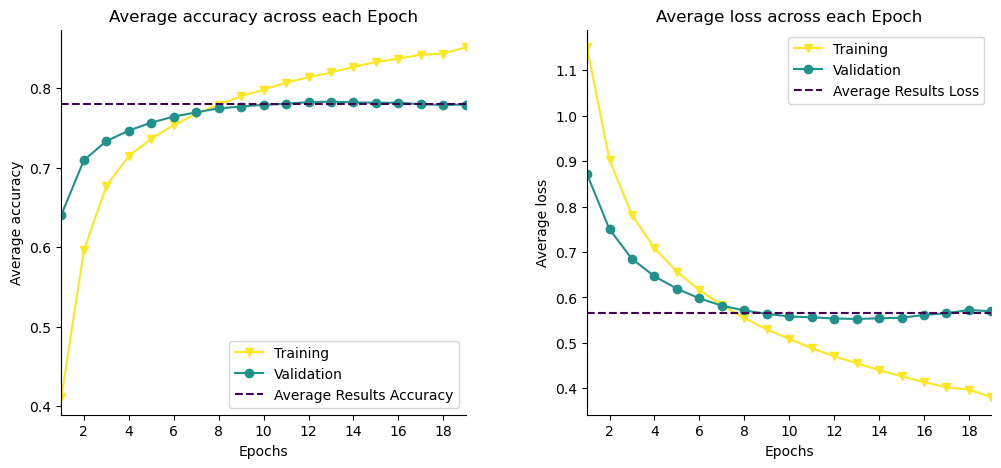

In [11]:
def create_averages(all_folds):
    averages = []
    all = deepcopy(all_folds)
    fold_lengths = [len(l) for l in all_folds]
    start = 0
    divisor = K
    for i in range(K):
        minimum = min(fold_lengths)
        for j in range(start, minimum):
            averages.append(sum([l[j] for l in all]) / (divisor - i))
        all.remove(all[fold_lengths.index(minimum)])
        fold_lengths.remove(minimum)
        start = minimum
    return averages

fig = plt.figure(figsize=(12, 5))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
cmap = matplotlib.colormaps.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, 3))

end = min(max([len(l) for l in all_val_losses]), EPOCHS)

average_training_scores = create_averages(all_train_scores)
average_validation_scores = create_averages(all_val_scores)
plt.subplot(1, 2, 1)
if display_training and len(average_training_scores) > end:
    training_length = len(average_training_scores)
    training_space = np.linspace(0, training_length - 1, end)
    interpolation = np.interp(training_space, range(training_length), average_training_scores).tolist()
    plt.plot(range(1, end + 1), interpolation, color=colours[2], marker='v', label='Training')
elif display_training:
    plt.plot(range(1, end + 1), average_training_scores[:end], color=colours[2], marker='v', label='Training')
plt.plot(range(1, end + 1), average_validation_scores[:end], color=colours[1], marker='o', label='Validation')
plt.axhline(y=avg_accuracy, color=colours[0], linestyle='--', label='Average Results Accuracy')
plt.title(f'Average accuracy across each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average accuracy')
plt.xlim(1, end)
plt.legend(loc='lower right')

average_training_losses = create_averages(all_train_losses)
average_validation_losses = create_averages(all_val_losses)
plt.subplot(1, 2, 2)
plt.plot(range(1, end + 1), average_training_losses[:end], color=colours[2], marker='v', label='Training')
plt.plot(range(1, end + 1), average_validation_losses[:end], color=colours[1], marker='o', label='Validation')
plt.axhline(y=avg_loss, color=colours[0], linestyle='--', label='Average Results Loss')
plt.title(f'Average loss across each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.xlim(1, end)
plt.legend(loc='upper right')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [9]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()
    
model = model.to('cpu')

In [10]:
message = input('Enter text to classify: ')

remove_links = lambda x: ' '.join([s for s in x.split() if 'http' not in s])
remove_punctuation = lambda x: ''.join([c for c in x if c not in r'!?()}{[]\'"“”`,,.…^+=/<>:;@#~%|¬\\£$€¥¢'])
swap_strings = lambda x: x.replace('-', ' ').replace('_', ' ').replace('&amp', 'and').replace('&', 'and').replace('colour', 'color').replace('centre', 'center').replace('favourite', 'favorite').replace('theatre', 'theater').replace('* * * *', '****').replace('* * *', '***').replace('* *', '**').replace('\n', ' ').replace('  ', ' ')
normalise = lambda x: swap_strings(remove_punctuation(remove_links(x.lower())))

label = lambda x: 'hate' if x == 2 else 'maybe hate' if x == 1 else 'not hate' if x == 0 else 'classification error'

print('"' + message + f'" is {label(predict(normalise(message), text_pipeline))}')

"Finlay duncan" is not hate
